In [1]:
import torch
import torch.nn as nn
import torchvision as tv
from torch.utils.data import DataLoader

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from typing import Tuple, List

%matplotlib inline

In [2]:
def get_mnist_ds(is_train:bool):
    return tv.datasets.MNIST(root = Path('mnistdata'),
                             train = is_train,
                             transform = tv.transforms.ToTensor(),
                             target_transform = None,
                             download = True
                            )

In [3]:
def get_mnist_ds_loader(batch_size):
        train_ds = get_mnist_ds(is_train = True)
        valid_ds = get_mnist_ds(is_train = False)
        
        return (DataLoader(train_ds, batch_size, shuffle = True),
                DataLoader(valid_ds, 2*batch_size, shuffle = False))
    

In [4]:
train_dl, valid_dl = get_mnist_ds_loader(32)

In [5]:
len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

In [6]:
train_dl.dataset.data.shape

torch.Size([60000, 28, 28])

torch.Size([32, 1, 28, 28])
torch.Size([32])


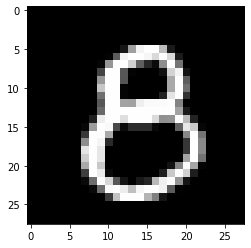

torch.Size([32, 1, 28, 28])
torch.Size([32])


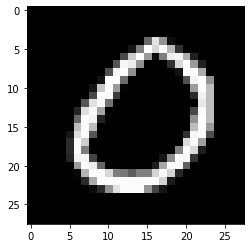

torch.Size([32, 1, 28, 28])
torch.Size([32])


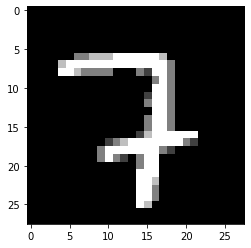

torch.Size([32, 1, 28, 28])
torch.Size([32])


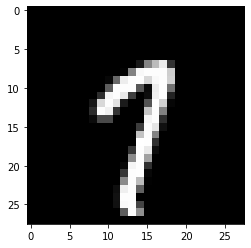

torch.Size([32, 1, 28, 28])
torch.Size([32])


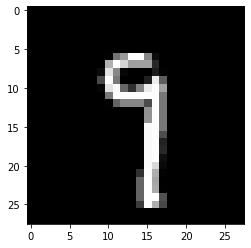

In [7]:
for i, x in enumerate(train_dl):
    print(x[0].shape)
    print(x[1].shape)
    plt.imshow(x[0][0][0],cmap='gray')
    plt.show()
    if i>3 : break

In [8]:
class Encoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        
        super().__init__()
        
        self.enc = nn.Sequential(nn.Flatten(),
                                 nn.Linear(np.prod(inp_size), hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, out_size))
        
    def forward(self, x):
        return self.enc(x)
        

In [108]:
class Decoder(nn.Module):
    def __init__(self, inp_size: int, hidden_size: int, out_size: Tuple[int,int]):
        
        super().__init__()
        self.out_size = out_size
        self.dec = nn.Sequential(nn.Linear(inp_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, np.prod(out_size)),
                                 nn.Sigmoid())
        
    def forward(self, x):
        x = self.dec(x)
        return x.view((x.shape[0],*self.out_size))

In [109]:
class AutoEncoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        super().__init__()
        
        self.enc = Encoder(inp_size, hidden_size, out_size)
        self.dec = Decoder(out_size, hidden_size, inp_size)
        
    def forward(self, x):
        out = self.enc(x)
        out = self.dec(out)
        
        return out

In [110]:
ae = AutoEncoder(inp_size=(28,28),hidden_size=512,out_size=20)

In [111]:
x = valid_dl.dataset[0][0]

In [112]:
x.shape

torch.Size([1, 28, 28])

In [113]:
out = ae(x)

In [114]:
out.shape

torch.Size([1, 28, 28])

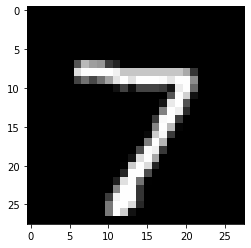

In [115]:
plt.imshow(x[0], cmap='gray')

TypeError: Invalid shape (28,) for image data

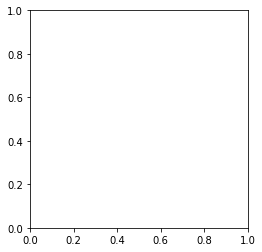

In [116]:
plt.imshow(out[0][0].detach().numpy(),cmap='gray')

In [ ]:
elem_num = 10

In [117]:
ae.train()

AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [118]:
%%time
actual_elems = [elem[0].unsqueeze(0) for i, elem in enumerate(valid_dl.dataset) if i < elem_num]

Wall time: 1.02 s


In [119]:
%%time
actual_elems_4d = torch.cat(actuals_elems)

Wall time: 0 ns


In [120]:
actual_elems_4d.requires_grad

False

In [121]:
actuals_elems_4d.shape

torch.Size([10, 1, 28, 28])

In [122]:
x = torch.randn((2,2))

In [123]:
x.requires_grad

False

In [124]:
%%time
with torch.no_grad():
    reconst_elems = ae(actuals_elems_4d)
ae.train()

Wall time: 4 ms


AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [125]:
%%time
grid_elems = [*actuals_elems_4d, *reconst_elems]

Wall time: 0 ns


In [126]:
%%time
grid = tv.utils.make_grid(grid_elems, nrow=elem_num, padding=1, pad_value =1).permute(1,2,0)

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 4 and 3 at C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\TH/generic/THTensor.cpp:603

In [127]:
grid.shape

torch.Size([59, 291, 3])

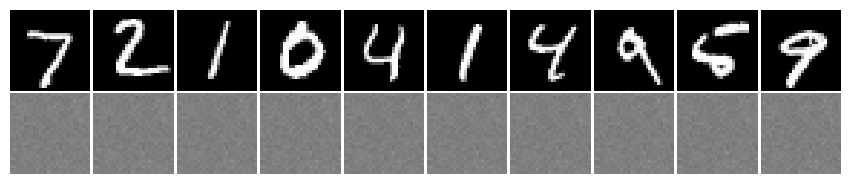

In [128]:
plt.figure(figsize=(15,15))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [149]:
def show_summary_1(valid_dl: DataLoader, model: nn.Module):
    ELEM_NUM = 10
    
    ae.eval()

    actuals_elems = [elem[0] for i, elem in enumerate(valid_dl.dataset) if i < ELEM_NUM]
    
    with torch.no_grad():
        actuals_to_device = torch.cat(actuals_elems)#.to(DEVICE)
        reconst_elems = ae(actuals_to_device).detach().cpu()
    
    

    
    ae.train()
    
    grid_elems = [*actuals_to_device, *reconst_elems]
    print('actual', actuals_to_device.shape)
    print('pred', reconst_elems.shape)
    grid = tv.utils.make_grid(grid_elems, nrow=elem_num, padding=1, pad_value =1).permute(1,2,0)
    
    plt.figure(figsize=(15,15))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [150]:
show_summary(valid_dl,ae)

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 4 and 3 at C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\TH/generic/THTensor.cpp:603

In [151]:
ae.eval()
actuals = []
reconst = []
with torch.no_grad():
    for i, elem in enumerate(valid_dl.dataset):
        x = elem[0]
        actuals.append(x)
        reconst.append(ae(x))
        if i >= 9: break
    

In [152]:
len(actuals)

10

In [153]:
actuals[2].shape

torch.Size([1, 28, 28])

In [154]:
reconst[0].shape

torch.Size([1, 28, 28])